In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from pandas.plotting import scatter_matrix

# model utils
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE

#model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


In [ ]:
def split_feat_label(data):
  x=data.iloc[:, :-1]
  y=data.iloc[:, -1]
  return x, y

## **Step 0. Load data**

In [ ]:
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Data/cancer_reg.csv

In [ ]:
df = pd.read_csv('cancer_reg.csv')

In [ ]:
df.shape

(3047, 33)

In [ ]:
df.head()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [ ]:
# reformat dataframe
df['label_deathrate']=df['target_deathrate']
df.drop(['target_deathrate'], axis=1, inplace=True)
df.head()

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,label_deathrate
0,1397.0,469,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,164.9
1,173.0,70,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,161.3
2,102.0,50,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,174.7
3,427.0,202,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,194.8
4,57.0,26,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,144.4


## **Step 1. Train and test split**

In [ ]:
# set seed
seed=1000
#features
x,y=split_feat_label(df)

#x=df.iloc[:, :-1]
#labels
#y=df.iloc[:, -1]
# split data: test, train 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, shuffle= True, random_state=seed)#

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

## **Step 2. Exploratory data analysis**

In [ ]:
train.shape

(2437, 33)

In [ ]:
# get data types
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2437 entries, 2152 to 1459
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              2437 non-null   float64
 1   avgdeathsperyear         2437 non-null   int64  
 2   incidencerate            2437 non-null   float64
 3   medincome                2437 non-null   int64  
 4   popest2015               2437 non-null   int64  
 5   povertypercent           2437 non-null   float64
 6   studypercap              2437 non-null   float64
 7   binnedinc                2437 non-null   object 
 8   medianage                2437 non-null   float64
 9   medianagemale            2437 non-null   float64
 10  medianagefemale          2437 non-null   float64
 11  geography                2437 non-null   object 
 12  percentmarried           2437 non-null   float64
 13  pctnohs18_24             2437 non-null   float64
 14  pcths18_24           

The dataset has 33 columns. The label is named: target_deathrate
Categorial features: geography, binnedinc.
Numerical features: the rest

In [ ]:
# calculate number of zeros 
train.isna().sum()/len(train)

avganncount                0.000000
avgdeathsperyear           0.000000
incidencerate              0.000000
medincome                  0.000000
popest2015                 0.000000
povertypercent             0.000000
studypercap                0.000000
binnedinc                  0.000000
medianage                  0.000000
medianagemale              0.000000
medianagefemale            0.000000
geography                  0.000000
percentmarried             0.000000
pctnohs18_24               0.000000
pcths18_24                 0.000000
pctsomecol18_24            0.745999
pctbachdeg18_24            0.000000
pcths25_over               0.000000
pctbachdeg25_over          0.000000
pctemployed16_over         0.054575
pctunemployed16_over       0.000000
pctprivatecoverage         0.000000
pctprivatecoveragealone    0.200246
pctempprivcoverage         0.000000
pctpubliccoverage          0.000000
pctpubliccoveragealone     0.000000
pctwhite                   0.000000
pctblack                   0

Features with NaN are:
1. pctsomecole18_24. It has almost 80% of NaN and therefore, it will be eliminated.
2. pctprivatecoveragealone. 20% of NaN values.
3. pctemployed16_over: 4% of NaN.

In [ ]:
# calculate stats on data
train.describe()

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,label_deathrate
count,2437.000000,2437.000000,2437.000000,2437.000000,2.437000e+03,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,619.000000,2437.000000,2437.000000,2437.00000,2304.000000,2437.000000,2437.000000,1949.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000,2437.000000
mean,596.767546,178.764054,448.175769,47117.872794,1.003379e+05,16.876898,157.080934,45.416742,39.490685,42.024497,51.852031,18.092080,34.937915,40.968336,6.194132,34.724949,13.29803,54.263889,7.830529,64.439639,48.605541,41.290808,36.130488,19.182314,83.701255,8.881050,1.280309,2.007750,51.300348,5.662295,178.382314
std,1429.205941,503.818020,53.223898,12193.198993,3.372530e+05,6.413158,525.568854,46.839371,5.256361,5.324059,6.856632,8.001975,9.254274,11.165068,4.521748,7.093766,5.41696,8.290916,3.443002,10.716624,10.135210,9.423292,7.845804,6.147876,16.263823,14.224030,2.727474,3.652719,6.504407,2.003879,27.899103
min,6.000000,3.000000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,22.300000,23.100000,0.000000,0.000000,7.100000,0.000000,7.500000,2.50000,19.500000,0.400000,22.300000,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000,59.700000
25%,76.000000,28.000000,420.800000,38848.000000,1.183000e+04,12.100000,0.000000,37.700000,36.300000,39.000000,47.900000,12.700000,29.000000,33.900000,3.100000,30.300000,9.40000,48.675000,5.500000,57.200000,41.200000,34.600000,30.700000,14.700000,77.347704,0.615891,0.258771,0.296354,47.792409,4.520914,160.800000
50%,171.000000,60.000000,453.549422,45180.000000,2.658900e+04,15.800000,0.000000,40.900000,39.500000,42.300000,52.500000,17.100000,34.600000,40.600000,5.400000,35.200000,12.30000,54.700000,7.500000,65.300000,48.800000,41.200000,36.300000,18.700000,90.075640,2.222103,0.548446,0.825917,51.726058,5.408652,177.800000
75%,518.000000,143.000000,480.800000,52448.000000,6.721500e+04,20.500000,82.482163,43.900000,42.500000,45.200000,56.400000,22.700000,40.700000,46.600000,8.300000,39.600000,16.10000,60.400000,9.700000,72.200000,55.800000,47.700000,41.400000,23.100000,95.408451,10.191814,1.213394,2.119182,55.446216,6.536926,195.200000
max,38150.000000,14010.000000,1014.200000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,65.700000,72.500000,62.700000,72.500000,79.000000,51.800000,54.800000,42.20000,80.100000,29.400000,92.300000,78.900000,70.700000,65.100000,46.600000,100.000000,82.559131,42.619425,41.930251,71.703057,18.556701,293.900000


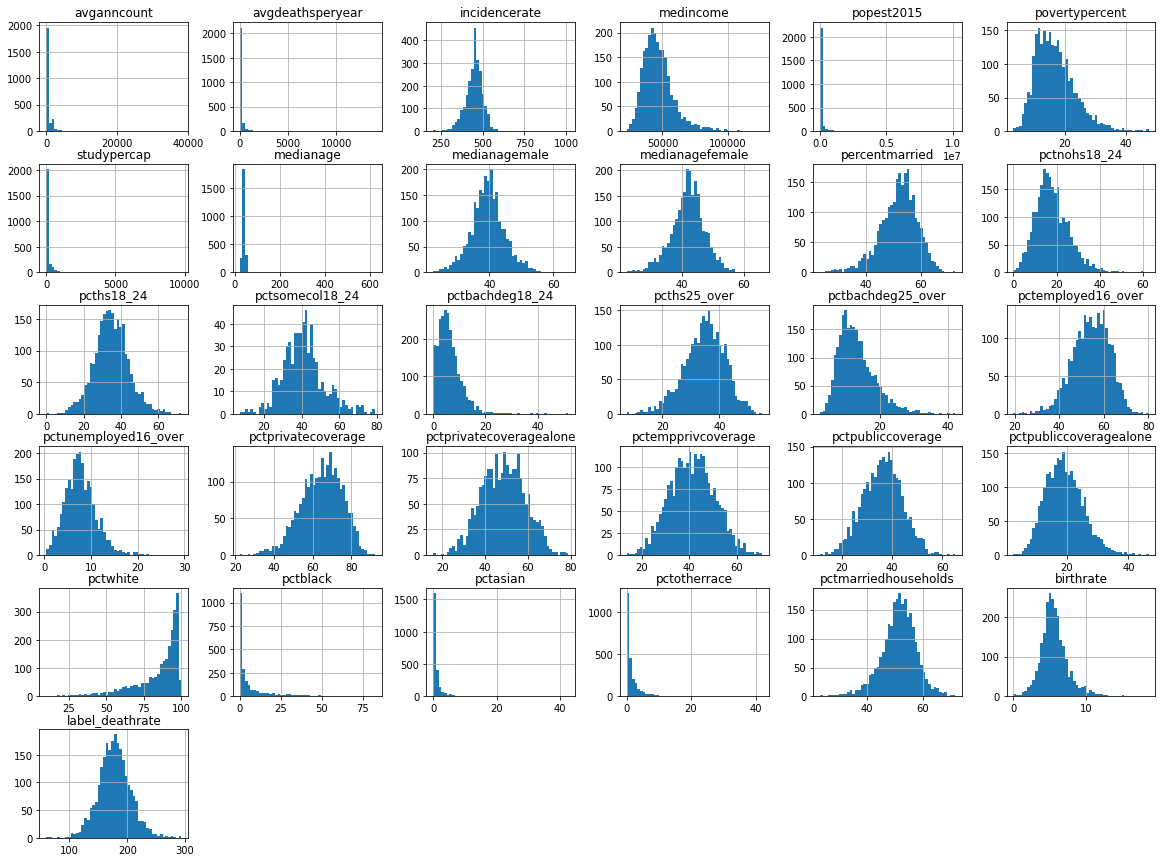

In [ ]:
train.hist(bins=50, figsize=(20,15)) 
plt.show();

From the plot above and the statistics report, it can be seen the some of the data is skewed and need to be transformed.

There is a total of 3,047 records. The data is composed of 32 features and 1 label: 

1.   Label target_deathRate: average per habitant (100,000) cancer deaths.


The goal is to predict the death rate.

There are missing values- need to define a ampute policy...
1. pctsomecol18_24: 75% missing values.
2. pctemployed16_over: 5% missing values.
3. pctprivatecoveragealone: 20% missing values.

Values with zeros, confirm if it is ok: 

1. studypercap : number of clinic trias linked tu cancer per habitat and county--zero seems to be ok in this case


High correlation betwen the target variable and the predictors:
mdincome, poverty percent, percentage higher than 25 yr, employed more than 16, unemployed more than 16


There is significant correlation among features: poverty rates, private insurance. This justify using lasso or ridge

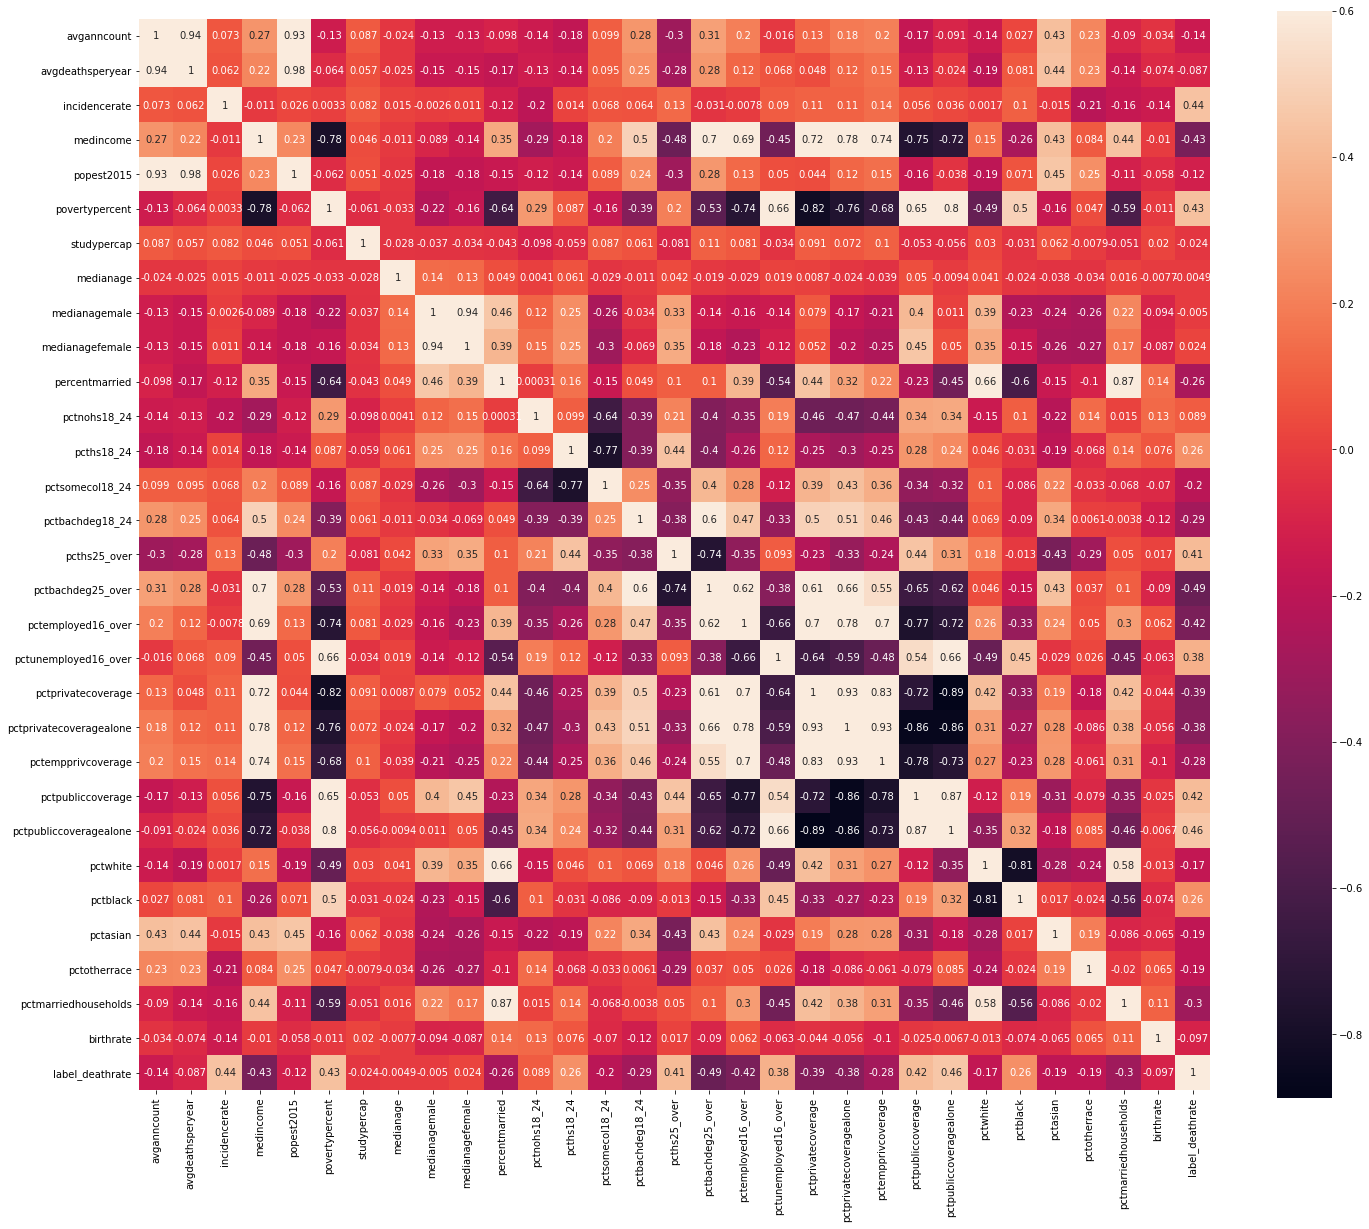

In [ ]:
#sns.pairplot(df)
plt.figure(figsize=(24,20))
sns.heatmap(train.corr(), vmax=0.6, square=True, annot=True);

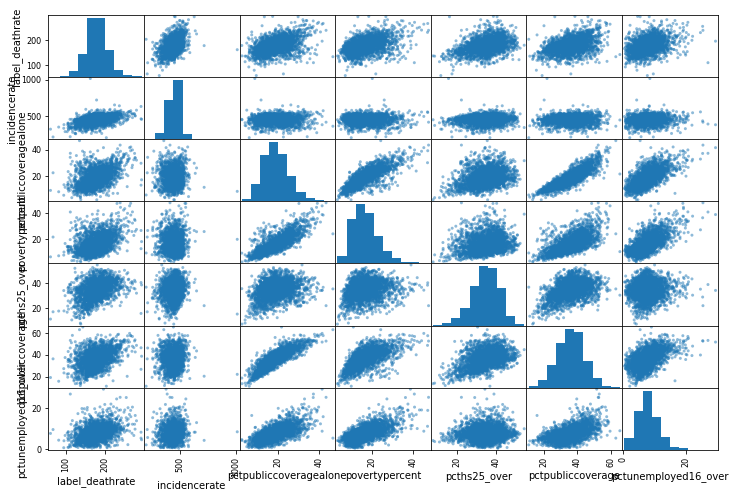

In [ ]:
# Let's pick the most relevant ones and generate a scatter matrix
attributes = ["label_deathrate", "incidencerate", "pctpubliccoveragealone", "povertypercent", "pcths25_over", 
              "pctpubliccoverage", "pctunemployed16_over"]
scatter_matrix(train[attributes], figsize=(12, 8));

It seems to be a linear relationship between the target variable and most of the features.

**Analysis of variables with NaN**

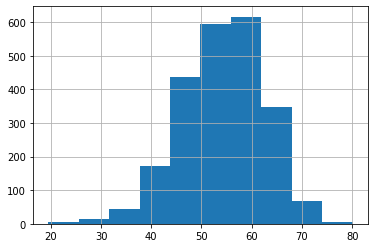

In [ ]:
# We can set the missing values in "pctemployed16_over" and in "pctprivatecoveragealone" to some value (zero, the mean, the median, etc.).
# First let's look at the distribution of the data.
train["pctemployed16_over"].hist();

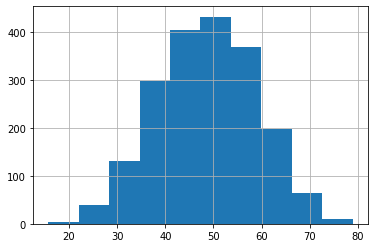

In [ ]:
train["pctprivatecoveragealone"].hist();

**Analysis geography feature**

In [ ]:
train['geography'] = train['geography'].str.rsplit(', ').str[-1] 
train['geography'].value_counts()

Texas             188
Georgia           126
Virginia          104
Kentucky           99
Missouri           91
Illinois           85
Kansas             84
Iowa               82
Tennessee          81
Minnesota          77
North Carolina     73
Ohio               71
Michigan           70
Oklahoma           64
Mississippi        63
Indiana            63
Nebraska           59
Arkansas           58
Alabama            55
Wisconsin          55
Colorado           51
Pennsylvania       50
South Dakota       49
Louisiana          49
New York           49
California         48
North Dakota       46
Florida            44
West Virginia      41
Montana            39
Idaho              35
South Carolina     35
Washington         29
Oregon             26
Utah               24
New Mexico         21
Wyoming            19
Maryland           17
Alaska             17
Maine              16
New Jersey         15
Nevada             12
Arizona            12
Massachusetts      10
Vermont            10
New Hampsh

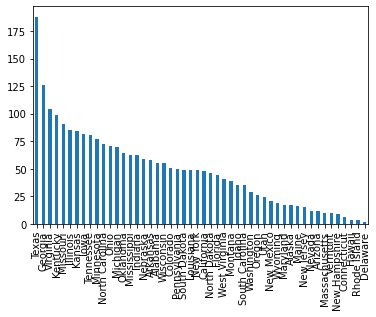

In [ ]:
train['geography'].value_counts().plot(kind='bar');

Data is skeweed on observations per state. Explore the number of minory per state. And then the error per geography of proportion of race.

## **Step 4. Feature engineering**

In [ ]:
def feature_eng(data):
  # features to drop
  drop_features=['pctsomecol18_24','geography']
  # categorical variables
  categorical_features=['binnedinc']
  # filter columns to drop
  every_feature= [col for col in data.columns if col not in drop_features]
  data=data[every_feature]
  # get numerical features
  every_column_non_categorical= [col for col in data.columns if col not in categorical_features]
  numeric_feats = data[every_column_non_categorical].dtypes[data.dtypes != "object"].index
  # apply log transformation to numerical varaibles
  data[numeric_feats] = np.log1p(data[numeric_feats])
  # apply one-hot encoding, remove 1 columen to keep the minimum of columns
  data = pd.get_dummies(data,columns =categorical_features, drop_first=True)

  # reformat data
  if 'label_deathrate' in data.columns:
    data['target']=data['label_deathrate']
    data.drop(['label_deathrate'], axis=1, inplace=True)
  return data

In [ ]:
train=feature_eng(train)
test=feature_eng(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
train.head()

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,percentmarried,pctnohs18_24,pcths18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,"binnedinc_(37413.8, 40362.7]","binnedinc_(40362.7, 42724.4]","binnedinc_(42724.4, 45201]","binnedinc_(45201, 48021.6]","binnedinc_(48021.6, 51046.4]","binnedinc_(51046.4, 54545.6]","binnedinc_(54545.6, 61494.5]","binnedinc_(61494.5, 125635]","binnedinc_[22640, 34218.1]",target
2152,4.919981,4.077537,6.075576,10.310851,10.093488,3.288402,0.000000,3.754199,3.701302,3.795489,3.716008,2.708050,3.478158,1.435085,3.523415,2.302585,3.790985,2.687847,4.010963,3.703768,3.558201,3.830813,3.332205,3.599711,4.083402,0.576451,0.791408,3.731344,1.931086,0,0,0,0,0,0,0,0,1,5.221976
2372,5.590987,4.691348,6.142252,10.629102,10.868987,3.173878,6.167517,3.535145,3.511545,3.558201,3.761200,2.001480,2.760010,2.501436,3.502550,2.714695,4.041295,2.370244,4.251348,4.003690,3.845883,3.563883,3.000720,4.542584,1.495115,0.695624,0.167962,3.789346,1.693391,0,1,0,0,0,0,0,0,0,5.176715
1649,6.333280,5.442418,6.110358,10.856477,11.554307,2.451005,6.406001,3.747148,3.720862,3.772761,4.005513,2.747271,3.742420,2.041220,3.634951,2.660260,4.110874,2.151762,4.304065,4.074142,4.007333,3.493473,2.850707,4.557865,1.155157,0.838889,0.155369,3.974037,1.765662,0,0,0,0,0,1,0,0,0,5.186268
528,4.532599,3.891820,5.984692,10.606709,9.781489,2.917771,0.000000,3.723281,3.693867,3.751854,4.027136,3.072693,3.728100,0.875469,3.723281,2.197225,3.864931,2.484907,4.039536,NaN,3.629660,3.781914,3.310543,4.562381,0.648332,0.255460,0.101064,4.011249,2.148755,0,1,0,0,0,0,0,0,0,5.311234
998,4.820282,4.007333,5.904544,10.819698,10.352842,3.015535,0.000000,3.637586,3.575151,3.811097,3.795489,3.496508,3.555348,0.788457,3.394508,2.208274,3.502550,2.476538,4.213608,3.923952,3.828641,3.678829,3.058707,4.329170,2.255852,0.920357,2.174992,3.960989,2.145893,0,0,0,0,1,0,0,0,0,5.141079


## **Step 5. Fit model**

In [ ]:
x_train, y_train = split_feat_label(train)
x_test, y_test = split_feat_label(test)

**Replace NaN with mean**

In [ ]:
col_mean=x_train.mean()
x_train=x_train.fillna(col_mean)
x_test=x_test.fillna(col_mean)

In [ ]:
col_mean

avganncount                      5.327923
avgdeathsperyear                 4.228457
incidencerate                    6.100038
medincome                       10.730706
popest2015                      10.324777
povertypercent                   2.821027
studypercap                      1.881080
medianage                        3.748315
medianagemale                    3.692444
medianagefemale                  3.753708
percentmarried                   3.958263
pctnohs18_24                     2.854956
pcths18_24                       3.544763
pctbachdeg18_24                  1.775500
pcths25_over                     3.553477
pctbachdeg25_over                2.592807
pctemployed16_over               3.999897
pctunemployed16_over             2.098072
pctprivatecoverage               4.166384
pctprivatecoveragealone          3.881858
pctempprivcoverage               3.718201
pctpubliccoverage                3.590350
pctpubliccoveragealone           2.955995
pctwhite                         4

**Cross-validation**

In [ ]:
# number of features 
numfeatures=x_train.shape[1]

In [ ]:
# do 10-folds crossvalidation
folds = KFold(n_splits = 10, shuffle = True, random_state = seed)

gridparameters = [{'n_features_to_select': list(range(2, numfeatures))}]

modelLR = LinearRegression()
modelLR.fit(x_train, y_train)
rfeLR = RFE(modelLR)             

modelrfeCV = GridSearchCV(estimator = rfeLR, 
                        param_grid = gridparameters, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [ ]:
# fit the model
modelrfeCV.fit(x_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   34.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=1000, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [ ]:
# extract crossvalidation results
modelrfeCV_results= pd.DataFrame(modelrfeCV.cv_results_)

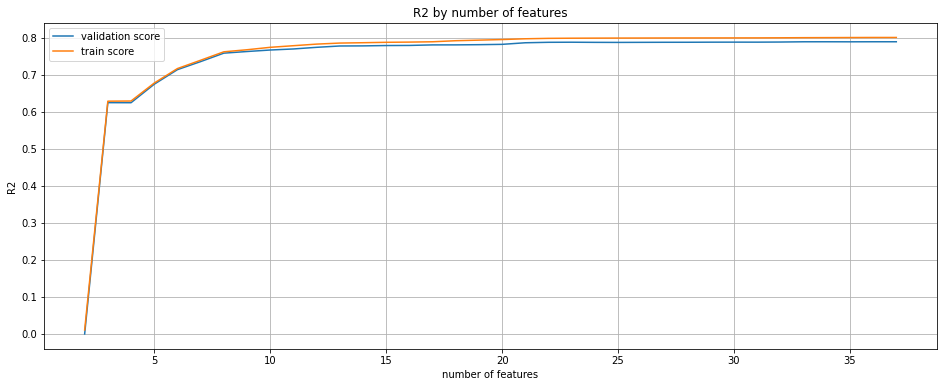

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(modelrfeCV_results["param_n_features_to_select"], modelrfeCV_results["mean_test_score"])
plt.plot(modelrfeCV_results["param_n_features_to_select"], modelrfeCV_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('R2')
plt.title("R2 by number of features")
plt.legend(['validation score', 'train score'])
plt.grid(True)
plt.show();

**Final model**

In [ ]:
# final model
best_numfeatures = 15 #20
LRfinal = LinearRegression()
LRfinal.fit(x_train, y_train)

rfeLRfinal = RFE(LRfinal, n_features_to_select=best_numfeatures)             
rfeLRfinal.fit(x_train, y_train)


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=15, step=1, verbose=0)

In [ ]:
list(zip(df.iloc[:, :-1].columns, rfeLRfinal.support_, rfeLRfinal.ranking_))

[('avganncount', False, 7),
 ('avgdeathsperyear', True, 1),
 ('incidencerate', True, 1),
 ('medincome', True, 1),
 ('popest2015', True, 1),
 ('povertypercent', False, 19),
 ('studypercap', False, 20),
 ('binnedinc', False, 14),
 ('medianage', True, 1),
 ('medianagemale', True, 1),
 ('medianagefemale', False, 6),
 ('geography', False, 12),
 ('percentmarried', True, 1),
 ('pctnohs18_24', False, 24),
 ('pcths18_24', False, 8),
 ('pctsomecol18_24', True, 1),
 ('pctbachdeg18_24', True, 1),
 ('pcths25_over', True, 1),
 ('pctbachdeg25_over', False, 4),
 ('pctemployed16_over', False, 15),
 ('pctunemployed16_over', False, 10),
 ('pctprivatecoverage', True, 1),
 ('pctprivatecoveragealone', True, 1),
 ('pctempprivcoverage', True, 1),
 ('pctpubliccoverage', False, 18),
 ('pctpubliccoveragealone', False, 9),
 ('pctwhite', False, 5),
 ('pctblack', True, 1),
 ('pctasian', False, 2),
 ('pctotherrace', False, 21),
 ('pctmarriedhouseholds', False, 23),
 ('birthrate', False, 16)]

In [ ]:
rfeLRfinal.score(x_train, y_train)


0.7865818867598591

Training error: 0.7954591379598865

In [ ]:
# get estimation of test error
scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error']
results_final = cross_validate(rfeLRfinal,
                        x_train,
                        y_train, 
                        scoring=scoring,
                        cv=folds,
                        return_train_score=True)


In [ ]:
results_finaldf= pd.DataFrame(results_final)
results_finaldf

,fit_time,score_time,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.093365,0.002767,0.775385,0.789122,-0.054536,-0.052957,-0.005690,-0.005373
1,0.092480,0.003095,0.781848,0.787100,-0.054298,-0.053217,-0.004983,-0.005483
2,0.088147,0.002875,0.756223,0.788350,-0.056085,-0.053358,-0.006768,-0.005336
3,0.119988,0.003289,0.810423,0.783904,-0.049730,-0.053707,-0.004688,-0.005522
4,0.094346,0.002811,0.777437,0.788587,-0.049308,-0.053552,-0.004978,-0.005458
5,0.102130,0.002736,0.784902,0.785258,-0.058266,-0.053002,-0.006297,-0.005368
6,0.099833,0.005805,0.792766,0.785578,-0.051371,-0.053665,-0.004689,-0.005528
7,0.134737,0.002769,0.823101,0.781528,-0.050841,-0.053797,-0.004654,-0.005535
8,0.089901,0.002825,0.808053,0.785047,-0.050996,-0.053447,-0.004555,-0.005506
9,0.143219,0.002768,0.674772,0.797678,-0.064331,-0.052306,-0.009145,-0.005090


In [ ]:
# calculate training R2 MAE, MSE
print('Train R-squared',results_finaldf['train_r2'].mean())
print('Train std deviation R-squared', results_finaldf['test_r2'].std())
print('Mean Absolute Error',-1*results_finaldf['train_neg_mean_absolute_error'].mean())
print('Mean Squared Error', -1*results_finaldf['train_neg_mean_squared_error'].mean())

Train R-squared 0.7872152834631232
Train std deviation R-squared 0.04137110257708458
Mean Absolute Error 0.05330070142946517
Mean Squared Error 0.005419850617184094


Train R-squared 0.7964686400970635

Mean Absolute Error 0.052788178610749005

Mean Squared Error 0.005564907897418134

In [ ]:
# calculate validation R2 MAE, MSE, RMSE
print('Validation mean R-squared', results_finaldf['test_r2'].mean())
print('Validation std deviation R-squared', results_finaldf['test_r2'].std())
print('Validation Mean Absolute Error',-1*results_finaldf['test_neg_mean_absolute_error'].mean())
print('Validation Mean Squared Error', -1*results_finaldf['test_neg_mean_squared_error'].mean())

Validation mean R-squared 0.7784909440771353
Validation std deviation R-squared 0.04137110257708458
Validation Mean Absolute Error 0.05397624225861212
Validation Mean Squared Error 0.005644844985400496


Validation R-squared 0.7703055245465571

Validation Mean Absolute Error 0.05468792338364187

Validation Mean Squared Error 0.006163608986047892

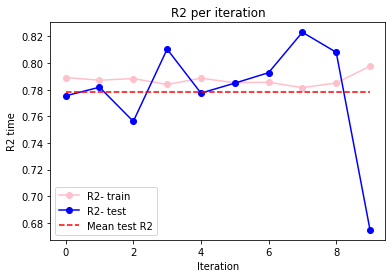

In [ ]:
r2_testavg = [np.mean(results_finaldf['test_r2'])]*len(results_finaldf)
plt.plot(results_finaldf.index,results_finaldf['train_r2'],label='R2- train', marker='o', color='pink')
plt.plot(results_finaldf.index,results_finaldf['test_r2'],label='R2- test', marker='o', color='blue')
plt.plot(results_finaldf.index,r2_testavg, label='Mean test R2', linestyle='--', color='red')
plt.xlabel('Iteration')
plt.ylabel('R2 time')
plt.title('R2 per iteration')
plt.legend(loc='lower left')
plt.show;

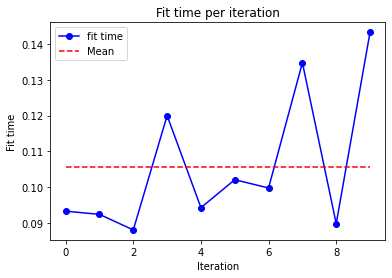

In [ ]:
fit_timeavg = [np.mean(results_finaldf['fit_time'])]*len(results_finaldf)
plt.plot(results_finaldf.index,results_finaldf['fit_time'],label='fit time', marker='o', color='blue')
plt.plot(results_finaldf.index,fit_timeavg, label='Mean', linestyle='--', color='red')
plt.xlabel('Iteration')
plt.ylabel('Fit time')
plt.title('Fit time per iteration')
plt.legend(loc='upper left')
plt.show;

In [ ]:
fittime_avg=np.mean(results_finaldf['fit_time'])
fittime_stddev=np.std(results_finaldf['fit_time'])  
print('Fit time- mean',fittime_avg)
print('Fit time- std deviation', fittime_stddev)

Fit time- mean 0.10581459999084472
Fit time- std deviation 0.01874971519048053


**Final score**

In [ ]:
#predict prices of x_valid
y_pred =rfeLRfinal.predict(x_test)
rfeLRfinal.score(x_test, y_test)

0.775022786054989

In [ ]:
print('Mean Absolute Error',metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error 0.05368768319995172
Mean Squared Error 0.005142375113444704
Root Mean Squared Error 0.07171035569180162


0.7881908670063877

Mean Absolute Error 0.05216923442173223

Mean Squared Error 0.004841388135301889

Root Mean Squared Error 0.0695800843295112

## **Step 6. Score model**

In [ ]:
#predict prices of x_valid
y_pred =rfeLRfinal.predict(x_test)
rfeLRfinal.score(x_test, y_test)

0.775022786054989

In [ ]:
print('Mean Absolute Error',metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error 0.05368768319995172
Mean Squared Error 0.005142375113444704
Root Mean Squared Error 0.07171035569180162


# **Step 7. Build paper**

In [1]:
!pip install -U pylatex
!pip install -U pdfLaTex
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! sudo apt-get install texlive
! sudo apt-get install latexmk  

     |████████████████████████████████| 92kB 4.0MB/s 
  Created wheel for pylatex: filename=PyLaTeX-1.4.1-cp37-none-any.whl size=42817 sha256=37f6bb717c63e098d8eaf6a1478cc18ae95424a657d5fa775bc9f28027e4c9b3
  Stored in directory: /root/.cache/pip/wheels/a2/25/3a/2cc0a6219d95ce34f1f7439a6427c62ca262ebaeb5969db89f
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8210 sha256=c13a0b3458d1a731e037d02a16e9f067dd4d45b92c04ce32a429a22bf2cf98de
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
Successfully built pylatex ordered-set
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: attrs 20.3.0
    Uninstalling attrs-20.3.0:
      Successfully uninstalled attrs-20.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:


In [2]:
import os

In [34]:
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Tex/paper.tex
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Tex/card.tex

In [26]:
# download figures
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/Logjustification.png
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/RFE.png
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/correlation.png
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/fittime.png
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/linearrelation.png
!wget -q https://raw.githubusercontent.com/MarthyGarcia/IFT6390_Project1/main/Figures/r_sqdtrainvalid.png

In [27]:
# generate model card
os.system("pdflatex card.tex")

0

In [35]:
# generate report 
os.system("pdflatex paper.tex")

0